In [1]:
from train_utils import *
import torch
from torch.utils.data import DataLoader
from dataset.dataset_loader import SNDataset,SNDatasetClimate, myNormalize, myToTensor, Augmentations
from torchvision import transforms
import random
import numpy as np
from dataset.utils.utils import TextColors as tc
from plot_utils.plot import plot_train_test_losses
from datetime import date, datetime
import json

c:\Users\moi3n\miniconda3\envs\pytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

In [3]:
# Format the date and time
now = datetime.now()
start_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", start_string)

Current Date and Time: 2023-05-08 12:38:58


In [4]:
import os
os.getcwd()

NAFISEH = "Nafiseh"
MOIEN = "Moien"

if "d:" in os.getcwd():
    USER = MOIEN
elif "c:" in os.getcwd():
    USER = NAFISEH
else:
    raise Exception("Unknown user")

USER

'Moien'

In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# CONFIG
NUM_WORKERS = 6 if USER == NAFISEH else 2
TRAIN_BATCH_SIZE = 32 if USER == NAFISEH else 4
TEST_BATCH_SIZE = 32 if USER == NAFISEH else 4
LEARNING_RATE = 1e-4 if USER == NAFISEH else 1e-4
NUM_EPOCHS = 100 if USER == NAFISEH else 5
LR_SCHEDULER = "step" # step, plateau or None

OC_MAX = 87
USE_SRTM = True

USE_SPATIAL_ATTENTION = True if USER == NAFISEH else False
USE_LSTM_BRANCH = True

In [7]:

if USE_SRTM:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)], [(12), (-4,2963)], [(13), (0, 90)]], oc_min = 0, oc_max = OC_MAX)
else:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)]], oc_min = 0, oc_max = OC_MAX)
    
my_to_tensor = myToTensor()
my_augmentation = Augmentations()
train_transform = transforms.Compose([mynorm, my_to_tensor,my_augmentation])
test_transform = transforms.Compose([mynorm, my_to_tensor])

In [ ]:
if USER == MOIEN:
    train_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\train\\'
    test_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\test\\'
    lucas_csv_path = 'D:\python\SoilNet\dataset\LUCAS_2015_all.csv'
    climate_csv_folder_path = "D:\\python\\SoilNet\\dataset\\Climate\\All\\filled\\"
    
elif USER == NAFISEH:
    train_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\l8_images\\train'
    test_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\l8_images\\test'
    lucas_csv_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\LUCAS_2015_all.csv'
    climate_csv_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\Climate\\All\\filled'

In [8]:
bands = [0,1,2,3,4,5,6,7,8,9,10,11] if not USE_SRTM else [0,1,2,3,4,5,6,7,8,9,10,11,12,13]


################################# IF Not USE_LSTM_BRANCH ###############################
if not USE_LSTM_BRANCH: # NOT USING THE CLIMATE DATA
    train_ds = SNDataset(train_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=train_transform)
    test_ds =  SNDataset(test_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform)
    
    
################################### IF USE_LSTM_BRANCH #################################
else: # USING THE CLIMATE DATA
    train_ds = SNDatasetClimate(train_l8_folder_path,
                                    lucas_csv_path,
                                    climate_csv_folder_path,
                                    l8_bands=bands, transform=train_transform)

    test_ds = SNDatasetClimate(test_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform)


In [ ]:
if USE_LSTM_BRANCH:
    

In [9]:
from soilnet.soil_net import SoilNetFC, ResNet, ResNetLSTM

In [10]:
# train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# # Get image and label from custom DataLoader
# img_custom, climate,label_custom = next(iter(train_dl))
# print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
# print(f"Climate shape: {climate.shape} -> [batch_size, climate_channels]")
# print(f"Label shape: {label_custom.shape}")
# img_gpu = img_custom.to(device)
# print(img_gpu.device, img_gpu.shape)
# print(img_gpu.shape)
# y = model(img_gpu)
# y.detach()

In [11]:
cv_results = {"train_loss": [],
               "test_loss": [],
               "MAE": [],
               "R2": []
    }

In [12]:
from datetime import date, datetime
# Format the date and time
now = datetime.now()
run_name = now.strftime("D_%Y_%m_%d_T_%H_%M")
print("Current Date and Time:", run_name)
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

Current Date and Time: D_2023_05_08_T_12_39


In [13]:
SEEDS = [1] if USER == MOIEN else [1, 4, 69, 75, 79, 128, 474, 786, 2048, 3333]

In [14]:
for idx, seed in enumerate(SEEDS):
    print(tc.BOLD_BAKGROUNDs.PURPLE, f"CROSS VAL {idx+1}", tc.ENDC)
    
    
    train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_dl = DataLoader(test_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    #model = SoilNetFC(cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
    architecture = "101+GLAM" if USE_SPATIAL_ATTENTION else "101"
    if USE_LSTM_BRANCH:
        model = ResNetLSTM(resnet_architecture=architecture, cnn_in_channels=len(bands), regresor_input_from_cnn=1024,
                       lstm_n_features= 14, lstm_n_layers= 2, lstm_out= 128,
                       hidden_size=128).to(device)
    else:
        model = ResNet(resnet_architecture=architecture, cnn_in_channels=len(bands), regresor_input_from_cnn=1024, hidden_size=128).to(device)
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Saving the model on the last epoch
    save_model_path = f"results/RUN_{run_name}_{USER}.pth.tar" if idx == len(SEEDS)-1 else None
    
    results = train(model, train_dl, test_dl,
                    torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
                    RMSELoss(), epochs=NUM_EPOCHS, lr_scheduler=LR_SCHEDULER,
                    save_model_path= save_model_path)

    
    cv_results['train_loss'].append(results['train_loss'])
    cv_results['test_loss'].append(results['test_loss'])
    cv_results['MAE'].append(results['MAE'][0])
    cv_results['R2'].append(results['R2'][0])
    
    
        

 CROSS VAL 1 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 13/13 [00:07<00:00,  1.76it/s, Train_Loss=0.74] 


KeyboardInterrupt: 

somehow the test_loss is smaller than train_loss -> could be due to small smaple dataset

In [ ]:
train_arr = np.asarray(cv_results['train_loss'])
test_arr = np.asarray(cv_results['test_loss'])
train_arr.shape, test_arr.shape

((1, 5), (1, 5))

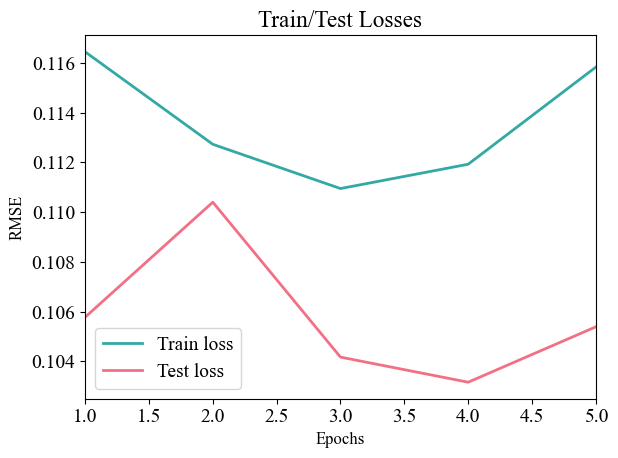

In [ ]:
plot_train_test_losses(train_arr,test_arr, title="Train/Test Losses", x_label="Epochs", y_label="RMSE", min_max_bounds= True, tight_x_lim= True, save_path=f"results/RUN_{run_name}_{USER}.png")

In [ ]:
import csv

In [ ]:
# Format the date and time
now = datetime.now()
finish_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", finish_string)

Current Date and Time: 2023-05-06 02:44:34


In [ ]:
cv_results["MAE"],cv_results["R2"]

([0.08959628355044585], [-1.2264364911959722])

In [ ]:
cv_results_full = {}
cv_results_full['MAE_MEAN'] = np.mean(cv_results['MAE'])
cv_results_full['R2_MEAN'] = np.mean(cv_results['R2'])
cv_results_full['MAE_MEAN'],cv_results_full['R2_MEAN']

(0.08959628355044585, -1.2264364911959722)

In [ ]:
cv_results_full['USE_LSTM_BRANCH'] = USE_LSTM_BRANCH
cv_results_full['NUM_WORKERS'] = NUM_WORKERS
cv_results_full['TRAIN_BATCH_SIZE'] = TRAIN_BATCH_SIZE
cv_results_full['TEST_BATCH_SIZE'] = TEST_BATCH_SIZE
cv_results_full['LEARNING_RATE'] = LEARNING_RATE
cv_results_full['NUM_EPOCHS'] = NUM_EPOCHS
cv_results_full['LR_SCHEDULER'] = LR_SCHEDULER
cv_results_full['USE_SPATIAL_ATTENTION'] = USE_SPATIAL_ATTENTION
cv_results_full['SEEDS'] = SEEDS
cv_results_full['OC_MAX'] = OC_MAX
cv_results_full['USE_SRTM'] = USE_SRTM
cv_results_full['TIME'] = {"start": start_string, "finish": finish_string}
cv_results_full['cv_results'] = cv_results

In [ ]:
with open(f"results/RUN_{run_name}_{USER}.json", "w") as fp:
    json.dump(cv_results_full, fp, indent=4)

In [ ]:
# READ JSON FILE
# with open("results/my_dict.json", "r") as fp:
#     my_dict = json.load(fp)

# print(my_dict)